<p style="text-align: center; font-size: 300%"> Computational Finance </p>
<img src="img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

In [1]:
#silence some warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting Basics

# Risk Measures
## Introduction
* The Basel Accords mandate that financial institutions report the risk associated with their positions, so that regulators may check the adequacy of the economic capital as a buffer against market risk.
* Reporting is the form of a *risk measure*, which condenses the risk of a position into a single number.
* Currently, the mandated measure is *Value at Risk*, but there are debates of replacing it with an alternative (*Expected Shortfall*).
* Banks are allowed to use their own, internal models for the computation of VaR, but the adequacy of these models should be *backtested*.


## Value at Risk
* Consider a portfolio with value $V_{t}$ and daily (simple) returns $
R_{t}$.
* Define the one-day loss on the portfolio as
$$
\$Loss_{t+1}=-\left[V_{t+1}-V_{t}\right].
$$
* I will distinguish between the dollar Value at Risk (an amount) and the return Value at Risk (a percentage). When unqualified, I mean the latter.
* The one-day $100p\%$ dollar Value at Risk
$\$VaR_{t+1}^{p}$ is the loss on the portfolio that we are $100\left(1-p\right) \%$ confident will not be exceeded. The Basel committee prescribes $p=0.01$.

* The *return Value at risk* $VaR_{t+1}^{p}$ expresses $\$VaR_{t+1}^{p}$ as a percentage of the portfolio value:
\begin{equation*}
VaR_{t+1}^{p}=\frac{\$VaR_{t+1}^{p}}{V_{t}}.
\end{equation*}
* Hence
\begin{equation*}
\Pr (R_{t+1}<-VaR_{t+1}^{p})=p,
\end{equation*}
because
\begin{equation*}
R_{t+1}=-\frac{\$Loss_{t+1}}{V_{t}}.
\end{equation*}
This holds approximately for log returns, too.
* Thus $VaR_{t+1}^{p}$ is minus the $100p$th *percentile*


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.stats as stats #The book likes to import it as `scs`
a, b, c = -5, 5, stats.norm.ppf(0.05)
x = np.linspace(a, b, 100)
y = stats.norm.pdf(x)
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)
plt.xlim(xmin=a, xmax=b)
Ix = np.linspace(a, c)
Iy = stats.norm.pdf(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(c, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)
ax.annotate('$p\%$', xy=(-2, 0.025), xytext=(-3, 0.1),
            arrowprops=dict(width=.5),
            )
plt.xlabel('$R_{PF,t+1}$')
plt.ylabel('$f(R_{PF,t+1})$')

ax.set_xticks([c, 0])
ax.set_xticklabels(['$-VaR_{t+1}^p$', '0'])
ax.set_yticks([])
plt.savefig('img/var.svg')
plt.close()

<img src="img/var.svg" alt="VaR" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## Asset Returns: Stylized Facts
* Stylized facts about asset returns include
  * Lack of autocorrelation
  * Leverage effects
  * Heavy tails of returns distribution
  * Volatility clustering
  
* These need to be taken into account when creating VaR forecasts. 


In [3]:
import pandas as pd
import pandas_datareader.data as web
p=web.DataReader("^GSPC", 'yahoo', start='1/1/2013', end='10/12/2017')['Adj Close']
r=np.log(p)-np.log(p).shift(1)
r.name='Return'
r=r[1:] #remove first observation (NaN)

In [4]:
import seaborn as sbs
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(121)
sbs.distplot(r, kde=False, fit=stats.norm) #histogram overlaid with fitted normal density
plt.subplot(122)
r.plot()
plt.savefig('img/stylizedfacts.svg')
plt.close()

<img src="img/stylizedfacts.svg" alt="Stylized Facts" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## VaR Methods: Unconditional
### Non-parametric: Historical Simulation

* Historical simulation assumes that the distribution of tomorrow's portfolio
returns is well approximated by the empirical distribution (histogram) of
the past $m$ observations $\left\{
R_{t}, R_{t-1},\ldots, R_{t+1-m}\right\} $.

* This is as if we draw, with replacement, from the last $m$ returns and use
this to simulate the next day's return distribution.

* The estimator of VaR is given by minus the $100p$th *percentile* (or the $p$th *quantile*) of the sequence of past portfolio returns, i.e., $\widehat{VaR}_{t+1}^{p}=-R^m_{p}$, where $R^m_{p}$ is the number such that $100p\%$ of the observations are smaller than it.


* In Python, we can use NumPy's `quantile` method, or the `percentile` function (or `nanpercentile` which ignores `NaN`s). Hilpisch uses `scoreatpercentile`, but that is is deprecated.

In [5]:
VaR_hist=-r.quantile(.01) #Alternatively, VaR=np.percentile(r,1)
VaR_hist

0.02131716077914799

In [6]:
ax=r.hist(bins=30) #histogram with 30 bins
ax.set_xticks([-VaR_hist])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_hist]) #4.3f means 4 digits, of which 3 decimals
plt.title('Historical VaR')
plt.savefig('img/var_hist.svg')
plt.close()

<img src="img/var_hist.svg" alt="VaR_hist" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Problem: Last year(s) of data not necessarily representative for the next few days (e.g. because of volatility clustering).
* Exacerbated by the fact that a large $m$ is required to compute 1% VaR with any degree of precision (only 1% of the data are really used).

### Parametric: Normal and $t$ Distributions
* Another simple approach is to
assume $R_{t+1}\sim N(\mu ,\sigma ^{2})$, and to estimate $\mu $
and $\sigma ^{2}$ using historical data (for daily data, $\mu \approx 0$).

* The VaR is then determined from
\begin{eqnarray*}
\Pr \left( R_{t+1}<-VaR_{t+1}^{p}\right) &=&\Pr \left( \frac{R_{t+1}-\mu }{%
\sigma }<\frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) \\
&=&\Pr \left( z_{t+1}<\frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) \\
&=&\Phi \left( \frac{-VaR_{t+1}^{p}-\mu }{\sigma }\right) =p,
\end{eqnarray*}
where $\Phi (z)$ is the cumulative standard normal distribution.

* Thus,
\begin{equation*}
VaR_{t+1}^{p}=-\mu -\sigma \Phi^{-1}(p),
\end{equation*}
where $\Phi ^{-1}(p)$ is the inverse distribution function of the standard normal, a.k.a. the percentage point function (ppf).
* In Python:

In [7]:
mu, sig=stats.norm.fit(r) #fit a normal distribution to r
VaR_norm=-mu-sig*stats.norm.ppf(0.01)
VaR_norm

0.017256428959902058

In [8]:
import seaborn as sbs
ax=sbs.distplot(r, kde=False, fit=stats.norm) #histogram overlaid with fitted normal density
ax.set_xticks([-VaR_norm])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_norm])
ax.text(0.02,60,'$\mu=%7.6f$\n$\sigma=%7.6f$' %(mu, sig)) #\n is newline
plt.title('Normal VaR')
plt.savefig('img/var_norm.svg')
plt.close()

<img src="img/var_norm.svg" alt="VaR_norm" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* Problems:
  * Variance of the past year(s) of data not necessarily representative for the future.
  * Returns typically have heavier tails than the normal.
* The solution to the second point is to use another distribution. The Student's $t$ distribution is a popular choice.

* The Student's $t$ distribution with $\nu$ degrees of freedom, $t_\nu$, is well known from linear regression
as the distribution of $t$-statistics, where $\nu=T-k$.

* Can be generalized to allow $\nu\in\mathbb{R}_+$.

* Small values of $\nu$ correspond to fat tails. As $\nu\rightarrow \infty $, we approach the $N(0,1)$ distribution.

* It only has moments up to but not including $\nu$:
  * The mean is finite only for $\nu>1$.
  * The variance is finite for $\nu>2$ and given by $\nu/(\nu-2)$.
  * The excess kurtosis is finite for $\nu>4$ and given by $6/(\nu-4)$.

* The distributions are symmetric around $0$, hence mean and skewness are $0$ if they exist.


In [9]:
x=np.linspace(-6,6,510)
df=[1, 2, 3, 10]
for nu in df:
    plt.plot(x, stats.t.pdf(x, nu))
legend=['$\\nu=%1.0f$' % nu for nu in df] #need double escaping: \\nu, not \nu, because \n is newline
plt.plot(x, stats.norm.pdf(x))
legend.append('Normal')
plt.legend(legend)
plt.savefig('img/tdists.svg')
plt.close()

<img src="img/tdists.svg" alt="t distributions" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* For financial applications, we need to allow for a non-zero mean, and a variance different from $\nu/(\nu-2)$.
* This is achieved by introducing a *location parameter* $\mu$ and a *scale parameter* $\sigma$. We'll write $f_\nu(x;\mu,\sigma)$ for the resulting density, $F_\nu(x;\mu,\sigma)$ for the distribution function, and $F^{-1}_\nu(p;\mu,\sigma)$ for the percentage point function.
* Note that if $x\sim t_\nu(\mu,\sigma)$, $\nu>2$, then $\mathbb{E}[x]=\mu$ and $\mathrm{var}[x]=\sigma^2\nu/(\nu-2)$.
* The VaR becomes
\begin{equation*}
VaR_{t+1}^{p}=-\mu -\sigma F^{-1}_\nu(p;\mu,\sigma).
\end{equation*}
* In Python:

In [10]:
df, mu, sig=stats.t.fit(r) #fit a location-scale t distribution to r
VaR_t=-mu-sig*stats.t.ppf(0.01, df)
VaR_t

0.021249089546776258

In [11]:
ax=sbs.distplot(r, kde=False, fit=stats.t) #histogram overlaid with fitted t density
ax.set_xticks([-VaR_t])
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR_t])
ax.text(0.02,60,'$\mu=%7.6f$\n$\sigma=%7.6f$\n$\\nu=%7.6f$' %(mu, sig, df))
plt.title("Student's $t$ VaR")
plt.savefig('img/var_t.svg')
plt.close()

<img src="img/var_t.svg" alt="VaR_t" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

* There are several ways to assess whether a distributional assumption is adequate.
* One is to use a *goodness of fit test*. Many such tests exist.
* Hilpisch discusses the D'Agostino-Pearson test, available as `stats.normaltest`. Here we use the Jarque-Bera test.
* The test statistic is
$
JB=N\left(S^2/6+(K-3)/24\right),
$
where $S$ and $K$ are respectively the sample skewness and kurtosis.
* Intuitively, it tests that the skewness and excess kurtosis are zero.
* It is distributed as $\chi^2_2$ under the null of normality. The 5% critical value is 

In [12]:
stats.chi2.ppf(0.95, 2)

5.9914645471079799

* In Python:

In [13]:
stats.jarque_bera(r) #returns (JB, p-val)

(411.09921326753727, 0.0)

* Another option is to use a QQ-plot (quantile-quantile plot).
* It plots the empirical quantiles against the quantiles of a hypothesized distribution, e.g. $\Phi^{-1}(p)$ for the normal.
* If the distributional assumption is correct, then the plot should trace out the 45 degree line.

In [14]:
#This is the manual way to do it.
%matplotlib inline
x=np.linspace(.01,.99)
emp=r.quantile(x)
mu, sig=stats.norm.fit(r)
theo=stats.norm.ppf(x, mu, sig)
ax=plt.plot(theo, emp.values, 'o')
#plt.xlim(xmin=-3, xmax=3)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot vs. Normal')
plt.savefig('img/qq_norm.svg')
plt.close()

<img src="img/qq_norm.svg" alt="QQ Plot" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

In [15]:
#this is a bit simpler
%matplotlib inline
import statsmodels.api as sm
sm.qqplot(r, dist=stats.t, fit=True)
plt.title("QQ Plot vs. Student's $t$")
plt.savefig('img/qq_t.svg')
plt.close()

<img src="img/qq_t.svg" alt="QQ Plot" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## VaR Methods: Filtered

* All methods discussed so far share one drawback: they assume that the volatility is constant, at least during in the estimation (and forecast) period. 
* Implicitly, the Normal and Student's $t$ method use the *historical volatility*: 
$$
\sigma _{t+1,HIST}^{2}=\frac{1}{m}\sum_{j=0}^{m-1}R_{t-j}^{2}
$$
(Note: volatility usually means standard deviation, not variance. I'll be sloppy about that).
* Here we assumed a zero mean, which is realistic for daily returns.
* Some adaptability is gained by choosing a smaller $m$ such as 250 (one trading year), but there is a tradeoff because doing so decreases the sample size.
* A general solution requires a *volatility model*, which will be discussed in *Advanced Risk Management*.

* A Pandas `Series` object has a `rolling` method that can be used to construct historial volatilities for an entire series, using, at each day, the past $m$ observations.
* The method returns a special window object that in turn has a method `var` (for variance).

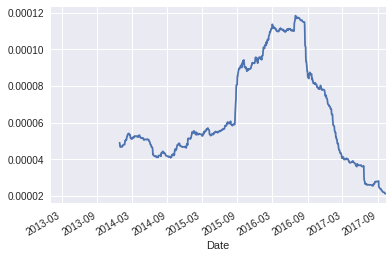

In [16]:
sig2_hist=r.rolling(window=250).var()
sig2_hist.plot();

* A partial solution to the drawbacks of historical volatility is given by the RiskMetrics model, which is a special case of a more general framework known as *GARCH* models.
* The idea is to replace the equally weighted moving average used in historical volatility by an exponentially weighted moving average (EWMA):
\begin{eqnarray*}
\sigma _{t+1,EWMA}^{2} &=&(1-\lambda )\sum_{j=0}^{\infty }\lambda
^{j}R_{t-j}^{2} \\
&=&\lambda \sigma _{t,EWMA}^{2}+(1-\lambda )R_{t}^{2},\qquad 0<\lambda <1.
\end{eqnarray*}

* This means that observations further in the past get a smaller weight.

* Smaller $\lambda$ means faster downweighting; for $\lambda\rightarrow 1$ we approach historical volatility (with an expanding window).

* In practice we do not have $R_{t-\infty }$, but the second equation
can be started up by an initial estimate / guess $\sigma _{0,EWMA}^{2}$.

* For daily data, RiskMetrics recommends $\lambda =0.94$.

* The `ewm` (exponentially moving average) method of a Pandas `Series` can be used to achieve something similar (the exact definition is slightly different, see [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)).
* As before, the method returns a window object that has a  `var` method.

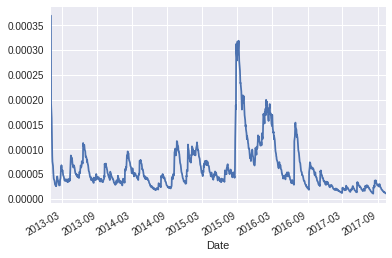

In [17]:
sig2_ewma=r.ewm(alpha=0.06).var() #alpha=(1-lambda)
sig2_ewma.plot();

* The idea behind a filtered VaR method is to decompose the returns as 
$$
R_t=\mu+\sigma_t z_t, \quad z_t\stackrel{\mathrm{\small i.i.d}}{\sim}(0,1),
$$
so that $\mathbb{E}[R_t]=\mu$ and $\mathrm{var}[R_t]=\sigma^2_t$. In principle, $\mu$ could be time-varying as well.
* $z_{p}$ denotes the $100p\%$ percentile of  
$$
z_t=\frac{R_t-\mu}{\sigma_t}.
$$
It can be estimated by applying any of the VaR methods above (historical, normal, or Student's t) to the *filtered* (demeaned and devolatized) returns
$$
\hat{z}_t=\frac{R_t-\hat{\mu}}{\hat{\sigma}_t}
$$
* Finally, $VaR_{t+1}^p=-\mu-\sigma_{t+1} z_{p}$.

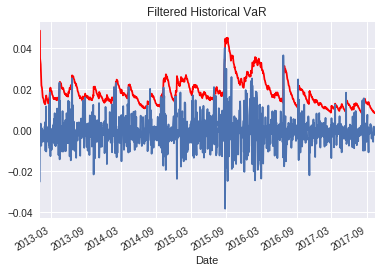

In [18]:
%matplotlib inline
sig_ewma=np.sqrt(sig2_ewma)
z=r/sig_ewma #assuming mu=0
VaR_filtered_hist=-sig_ewma*z.quantile(0.01)
VaR_filtered_hist.plot(color='red');
plt.plot(-r)
plt.title('Filtered Historical VaR');

## Backtesting
* The Basel accords require that methods to evaluate VaR be
backtested.

* They recommend constructing the 1% VaR over the last 250 trading days
and counting the number of *VaR exceptions* (times losses exceed the day's VaR figure).

* A method is said to lie in the:

  * Green zone, in case of 0-4 exceptions;
  * Yellow zone, in case of 5-9 exceptions;
  * Red zone, in case of 10 or more exceptions.
* Being in one of the latter two incurs an extra capital charge.

* A more advanced method is the *dynamic quantile* (DQ) test by Engle and Manganelli (2004).
* It is based on the *hit series*
\begin{equation*}
I_{t}=\left\{
\begin{array}{cc}
1, & \text{if }r_{t}<-VaR_{t}^{p}, \\
0, & \text{if }r_{t}>-VaR_{t}^{p}.
\end{array}
\right.
\end{equation*}
* If the VaR model is correctly specified, then $\mathbb{E}[I_t]=p$ (there should be about $p\cdot T$ exceptions in a sample of size $T$). This is known as the *unconditional coverage hypothesis*.
* It can be tested by regressing $I_t-p$ on an intercept and testing that it is zero.
* In addition, it is desirable that the exceptions not be correlated. This is the *independence hypothesis*. It can be tested be including lags of $I_t$ in the regression and testing their significance.
* Jointly testing both (with an $F$ test) tests the *conditional coverage* hypothesis.

In [25]:
import statsmodels.formula.api as smf
y=(r<-VaR_filtered_hist)*1 #multiplication by 1 turns True/False into 1/0
y.name='I'
data=pd.DataFrame(y)
model=smf.ols('I.subtract(0.01)~I.shift(1)', data=data)
res=model.fit()
print(res.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.020     
Dependent Variable: I.subtract(0.01) AIC:                -2069.9720
Date:               2017-10-12 18:01 BIC:                -2059.7852
No. Observations:   1204             Log-Likelihood:     1037.0    
Df Model:           1                F-statistic:        25.67     
Df Residuals:       1202             Prob (F-statistic): 4.68e-07  
R-squared:          0.021            Scale:              0.010475  
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
Intercept    -0.0008     0.0030   -0.2576   0.7967   -0.0066   0.0051
I.shift(1)    0.1446     0.0285    5.0669   0.0000    0.0886   0.2006
-------------------------------------------------------------------
Omnibus:            1816.402      Durbin-Watson:        

* Conclusions:
  * Unconditional coverage is not rejected. This is by construction; note that $r_{t}\lessgtr-VaR_{t}^{p}\Longleftrightarrow z_t\lessgtr z_p$.
  * Independence is rejected; apparently our model is dynamically mis-specified. May need to use a GARCH model instead of EWMA.
* The latter finding is likely driving the rejection of the conditional coverage test:
  

In [20]:
print(res.f_test('Intercept=0, I.shift(1)=0'))

<F test: F=array([[ 12.87315967]]), p=2.93962494772e-06, df_denom=1202, df_num=2>
